# MMI Surrogate Modeling

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
from tidy3d.plugins.mode import ModeSolver
import tidy3d.plugins.design as tdd

Constants used to create the 1x4 MMI `Simulation`

In [2]:
# material refractive indices
n_si = 3.48
n_gan = 2.305
n_sio2 = 1.444

# define media
si = td.Medium(permittivity=n_si**2)
gan = td.Medium(permittivity=n_gan**2)
sio2 = td.Medium(permittivity=n_sio2**2)

W_MMI = 5  # width of the MMI section
L_MMI = 11.2  # length of the MMI section
g1 = 0.9  # gap between the output waveguides
W1 = 0.4  # width of the waveguide
W2 = 0.8  # width of the tapper
L1 = 2  # length of the input tapper
L2 = 5  # length of the output tapper
H_Si = 0.3  # thickness of the Si layer
H_GaN = 0.1  # thickness of the GaN layer
g3 = (W2 - W1) / 2  # auxilary parameter defined for easier geometry building
g2 = g1 - 2 * g3  # gap between the output tapers
lda0 = 1.55  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(1.5, 1.6, 101)  # wavelength range
freqs = td.C_0 / ldas  # frequency range
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))

# buffer spacings in the x and y directions.
buffer_x = 1
buffer_y = 1.5

Build the MMI `Simulation` from the width and length of the body of the MMI

In [3]:
# define a function that takes the geometric parameters as input arguments and return a Simulation object
def make_sim(L_MMI, W_MMI):
    # the whole device is defined as a PolySlab with vertices given by the following
    vertices = np.array(
        [
            (-W1 / 2, -100),
            (-W1 / 2, 0),
            (-W2 / 2, L1),
            (-W_MMI / 2, L1),
            (-W_MMI / 2, L1 + L_MMI),
            (-g2 / 2 - W2 - g2 - 2 * g3 - W1, L1 + L_MMI),
            (-g2 / 2 - W2 - g2 - g3 - W1, L1 + L_MMI + L2),
            (-g2 / 2 - W2 - g2 - g3 - W1, 100),
            (-g2 / 2 - W2 - g2 - g3, 100),
            (-g2 / 2 - W2 - g2 - g3, L1 + L_MMI + L2),
            (-g2 / 2 - W2 - g2, L1 + L_MMI),
            (-g2 / 2 - W2, L1 + L_MMI),
            (-g1 / 2 - W1, L1 + L_MMI + L2),
            (-g1 / 2 - W1, 100),
            (-g1 / 2, 100),
            (-g1 / 2, L1 + L_MMI + L2),
            (-g2 / 2, L1 + L_MMI),
            (g2 / 2, L1 + L_MMI),
            (g1 / 2, L1 + L_MMI + L2),
            (g1 / 2, 100),
            (g1 / 2 + W1, 100),
            (g1 / 2 + W1, L1 + L_MMI + L2),
            (g2 / 2 + W2, L1 + L_MMI),
            (g2 / 2 + W2 + g2, L1 + L_MMI),
            (g2 / 2 + W2 + g2 + g3, L1 + L_MMI + L2),
            (g1 / 2 + W1 + g1, 100),
            (g1 / 2 + W1 + g1 + W1, 100),
            (g2 / 2 + W2 + g2 + g3 + W1, L1 + L_MMI + L2),
            (g2 / 2 + W2 + g2 + 2 * g3 + W1, L1 + L_MMI),
            (W_MMI / 2, L1 + L_MMI),
            (W_MMI / 2, L1),
            (W2 / 2, L1),
            (W1 / 2, 0),
            (W1 / 2, -100),
        ]
    )

    mmi_layer1 = td.Structure(
        geometry=td.PolySlab(
            vertices=vertices,
            axis=2,
            slab_bounds=(-H_Si - 0.5 * H_GaN, H_Si + 0.5 * H_GaN),
        ),
        medium=si,
    )
    mmi_layer2 = td.Structure(
        geometry=td.PolySlab(
            vertices=vertices, axis=2, slab_bounds=(-0.5 * H_GaN, 0.5 * H_GaN)
        ),
        medium=gan,
    )

    # simulation domain size
    Lx = W_MMI + 2 * buffer_x
    Ly = L1 + L_MMI + L2 + 2 * buffer_y
    Lz = 5 * (H_GaN * 2 + H_Si)
    sim_size = (Lx, Ly, Lz)

    mode_spec = td.ModeSpec(num_modes=2, target_neff=n_si)

    # add a mode source for excitation
    mode_source = td.ModeSource(
        center=(0, -buffer_y / 2, 0),
        size=(5 * W1, 0, Lz),
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
        direction="+",
        mode_spec=mode_spec,
        mode_index=0,
        num_freqs=5,
    )

    # add two flux monitors to monitor the transmission power at output waveguides
    flux_monitor1 = td.FluxMonitor(
        center=((g1 + W1) / 2, Ly - 3 * buffer_y / 2, 0),
        size=(3 * W1, 0, Lz),
        freqs=freqs,
        name="flux1",
    )

    flux_monitor2 = td.FluxMonitor(
        center=(3 * (g1 + W1) / 2, Ly - 3 * buffer_y / 2, 0),
        size=(3 * W1, 0, Lz),
        freqs=freqs,
        name="flux2",
    )

    # add two mode monitors to monitor the mode profiles at output waveguides
    mode_monitor1 = td.ModeMonitor(
        center=((g1 + W1) / 2, Ly - 3 * buffer_y / 2, 0),
        size=(3 * W1, 0, Lz),
        freqs=freqs,
        mode_spec=mode_spec,
        name="mode1",
    )

    mode_monitor2 = td.ModeMonitor(
        center=(3 * (g1 + W1) / 2, Ly - 3 * buffer_y / 2, 0),
        size=(3 * W1, 0, Lz),
        freqs=freqs,
        mode_spec=mode_spec,
        name="mode2",
    )

    # Commented out to make sim cheaper
    # add a field monitor to monitor the field distribution
    # field_monitor = td.FieldMonitor(
    #     center=(0, 0, 0), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
    # )

    sim = td.Simulation(
        center=(0, Ly / 2 - buffer_y, 0),
        size=sim_size,
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=td.C_0 / freq0),
        structures=[mmi_layer1, mmi_layer2],
        sources=[mode_source],
        monitors=[
            # field_monitor,
            flux_monitor1,
            flux_monitor2,
            mode_monitor1,
            mode_monitor2,
        ],
        run_time=5e-12,
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
        medium=sio2,
        symmetry=(1, 0, -1),
    )
    return sim

Check the `Simulation` geometry by plotting the shape

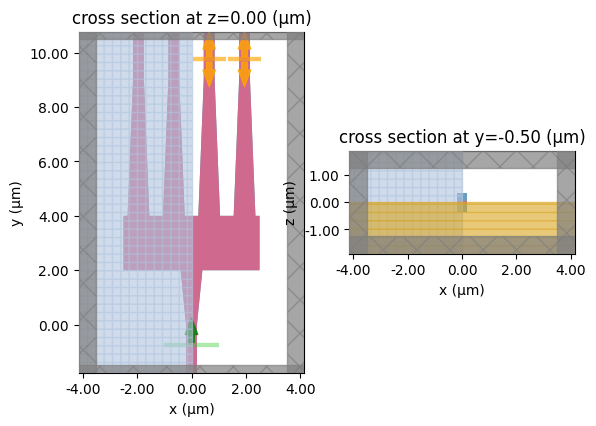

In [4]:
f, (ax1, ax2) = plt.subplots(1, 2)
sim = make_sim(2, 5)
sim.plot(z=0, ax=ax1)
sim.plot(y=-buffer_y / 3, ax=ax2)
plt.show()

Define a small `fn_post` function to extract the flux of the inner and outer output ports

In [5]:
def fn_post(sim_data):
    T1 = sim_data["flux1"].flux
    T2 = sim_data["flux2"].flux
    return {"T1": T1, "T2": T2}

Use a Monte Carlo sample to create an initial dataset

In [6]:
method = tdd.MethodMonteCarlo(
    num_points=100,
    seed=2,
)

l_param = tdd.ParameterFloat(name="L_MMI", span=(6, 16))
w_param = tdd.ParameterFloat(name="W_MMI", span=(5, 10))
parameters = [l_param, w_param]

output_dir = "/home/matt/Documents/Flexcompute/mmi/data"
design_space = tdd.DesignSpace(
    method=method,
    parameters=parameters,
    task_name="mmi_2",
    folder_name="MMIV2",
    path_dir=output_dir,
)


Run the sampler

In [7]:
results = design_space.run(make_sim, fn_post, verbose=False)
df = results.to_dataframe()

17:16:50 BST WARNING: Simulation final field decay value of 2.24e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

17:16:55 BST WARNING: Simulation final field decay value of 2.94e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

17:16:56 BST WARNING: Simulation final field decay value of 3.71e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Simulation final field decay value of 1.11e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

17:16:57 BST WARNING: Simulation final field decay value of 3.12e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Simulation final field decay value of 1.05e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

17:16:58 BST WARNING: Simulation final field decay value of 2.08e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

17:17:03 BST WARNING: Simulation final field decay value of 2.82e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

17:17:05 BST WARNING: Simulation final field decay value of 1.79e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

17:17:08 BST WARNING: Simulation final field decay value of 1.59e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

17:17:09 BST WARNING: Simulation final field decay value of 1.43e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

17:17:10 BST WARNING: Simulation final field decay value of 1.12e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

17:17:11 BST WARNING: Simulation final field decay value of 1.01e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

In [7]:
# TESTING: Save off the df or load the df
import pickle
import os
os.chdir("/home/matt/Documents/Flexcompute/surrogate_data/mmi/data")
# with open("result_100.pkl", "wb") as out_file:
#     pickle.dump(results, out_file)


with open("result_100.pkl", "rb") as in_file:
    results = pickle.load(in_file)

df = results.to_dataframe()

# df.to_pickle("/home/matt/Documents/Flexcompute/mmi/data/df.pkl")

# with open("df.pkl", "rb") as in_file:
#     df = pickle.load(in_file)

Plot distribution of width and length data in the training dataset

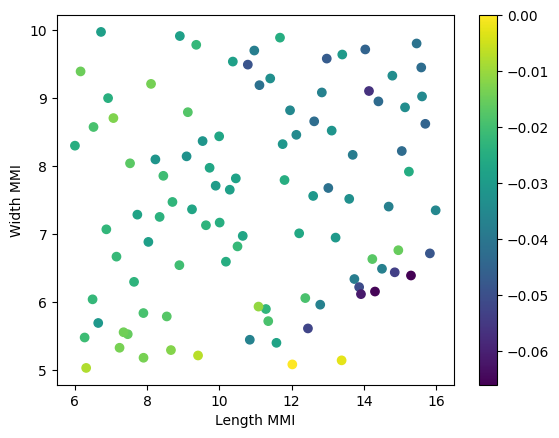

In [10]:
import matplotlib.colors as mcolors
# df.plot.scatter("W_MMI", "L_MMI")

fitness_val = -(abs(df["T1_cent"] - 0.25)**2 + abs(df["T2_cent"] - 0.25)**2)

norm = mcolors.Normalize(vmin=0, vmax=-0.06)

scatter = plt.scatter(df["L_MMI"], df["W_MMI"], c=fitness_val, norm=norm)
plt.xlabel("Length MMI")
plt.ylabel("Width MMI")
plt.colorbar(scatter)
plt.show()

## Surrogate

Get the label information from within the x_array stored in the results

In [9]:
# Get T1 and T2 averages
df["T1_mean"] = df["T1"].apply(lambda x: float(x.mean()))
df["T2_mean"] = df["T2"].apply(lambda x: float(x.mean()))

# Get T1 and T2 central freq values
df["T1_cent"] = df["T1"].apply(lambda x: float(x[int(len(df["T1"]) / 2)]))
df["T2_cent"] = df["T2"].apply(lambda x: float(x[int(len(df["T2"]) / 2)]))

Define an AI model that will be trained on data stored in a `pandas.DataFrame`

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

from tidy3d.plugins.design.surrogate_object import AI_Model

# Constants
output_dir = "/home/matt/Documents/Flexcompute/surrogate_data/mmi"
data_dir = ["/home/matt/Documents/Flexcompute/surrogate_data/mmi/data/"]

test_percentage = 0.20
valid_percentage = 0.20
batch_size = 15
epochs = 100

trial_count = 40

model = AI_Model(output_dir, data_dir, seed=11)

model.load_data_from_df(
    df=df,
    label_names=["T1_cent", "T2_cent"],
    feature_names=["L_MMI", "W_MMI"],
    test_percentage=test_percentage,
    valid_percentage=valid_percentage,
    batch_size=batch_size,
    individual_feature_scaling=True
)

loss_fn = nn.MSELoss()


Using existing directory at pickle_data
Using existing directory at models
Using device cuda:0


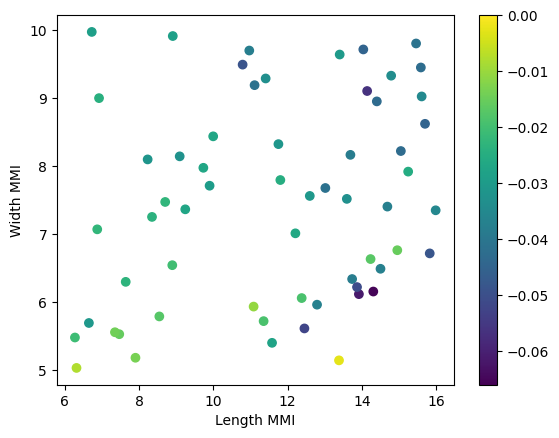

In [31]:
# TESTING
import matplotlib.colors as mcolors
features = [x for x, _ in model.train_loaded]
combined = torch.concat(features)
l = [model.feature_scaler[0].inverse_transform(row[0].reshape(1, -1)) for row in combined]
w = [model.feature_scaler[1].inverse_transform(row[1].reshape(1, -1)) for row in combined]

T1_val = np.array([row[0] for row in model.train_labels])
T2_val = np.array([row[1] for row in model.train_labels])

fitness_val = -(abs(T1_val - 0.25)**2 + abs(T2_val - 0.25)**2)

norm = mcolors.Normalize(vmin=0, vmax=-0.06)

scatter = plt.scatter(l, w, c=fitness_val, norm=norm)
plt.xlabel("Length MMI")
plt.ylabel("Width MMI")
plt.colorbar(scatter)
plt.show()

Define a Pytorch model that can be used for training. Also works with model optimization

In [12]:
# Define the model in PyTorch
class VariableANN(nn.Module):
    def __init__(self, input_size, neurons, dropout) -> None:
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, neurons[0]))

        for i in range(1, len(neurons)):
            self.layers.append(nn.Linear(neurons[i - 1], neurons[i]))

        self.layers.append(nn.Linear(neurons[-1], 2))

        self.drop = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.drop(self.relu(layer(x)))

        x = self.layers[-1](x)

        return x

Train a model based on arbitrary hyperparameters

Using existing directory at Model1


 30%|███       | 30/100 [00:00<00:00, 103.34it/s]

Best State Updated. Epoch: 0
Best State Updated. Epoch: 1
Best State Updated. Epoch: 2
Best State Updated. Epoch: 4
Best State Updated. Epoch: 5
Best State Updated. Epoch: 22
Best State Updated. Epoch: 28
Best State Updated. Epoch: 30
Best State Updated. Epoch: 31
Best State Updated. Epoch: 32
Best State Updated. Epoch: 36
Best State Updated. Epoch: 38
Best State Updated. Epoch: 39
Best State Updated. Epoch: 40
Best State Updated. Epoch: 41
Best State Updated. Epoch: 43
Best State Updated. Epoch: 44
Best State Updated. Epoch: 45
Best State Updated. Epoch: 47
Best State Updated. Epoch: 49
Best State Updated. Epoch: 51
Best State Updated. Epoch: 53
Best State Updated. Epoch: 55
Best State Updated. Epoch: 57
Best State Updated. Epoch: 59
Best State Updated. Epoch: 60
Best State Updated. Epoch: 61


 93%|█████████▎| 93/100 [00:00<00:00, 214.99it/s]

Best State Updated. Epoch: 62
Best State Updated. Epoch: 63
Best State Updated. Epoch: 64
Best State Updated. Epoch: 65
Best State Updated. Epoch: 68
Best State Updated. Epoch: 69
Best State Updated. Epoch: 73
Best State Updated. Epoch: 76
Best State Updated. Epoch: 77
Best State Updated. Epoch: 80
Best State Updated. Epoch: 84
Best State Updated. Epoch: 91
Best State Updated. Epoch: 94
Best State Updated. Epoch: 98


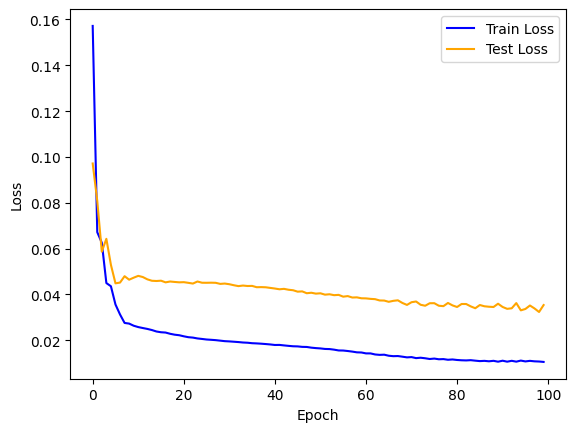

100%|██████████| 100/100 [00:00<00:00, 154.81it/s]

 Best Test Loss: 0.03233182430267334
RMSE: 0.029587
MAE: 0.023791


In [13]:
# Create single model
network = VariableANN(2, [144, 96, 80], 0.0)
opt = optim.Adam(network.parameters(), lr=0.00245, weight_decay=1.515e-5)

trained_net = model.train_model("Model1", network, opt, loss_fn, epochs, plot_output=True)
test_rmse, _, test_predictions = model.validate_model(trained_net, "test")

Alternatively, sweep through the model design space and find the optimum model architecture

[I 2024-09-11 11:15:01,122] A new study created in memory with name: no-name-80e891c9-ec47-41d2-8160-f97697999a0a


Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 244.09it/s]
[I 2024-09-11 11:15:03,117] Trial 0 finished with value: 0.02746 and parameters: {'dropout': 0.05, 'neurons0': 16, 'neurons1': 128, 'neurons2': 192, 'neurons3': 112, 'lr': 0.0008743964639665052, 'weight_decay': 1.0606244371253567e-05}. Best is trial 0 with value: 0.02746.


 Best Test Loss: 0.05635766685009003
RMSE: 0.02746
MAE: 0.021906
Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 257.81it/s]
[I 2024-09-11 11:15:04,673] Trial 1 finished with value: 0.036448 and parameters: {'dropout': 0.25, 'neurons0': 256, 'neurons1': 224, 'neurons2': 192, 'neurons3': 32, 'lr': 0.03763714577477794, 'weight_decay': 0.0005179746363093499}. Best is trial 0 with value: 0.02746.


 Best Test Loss: 0.11370731890201569
RMSE: 0.036448
MAE: 0.0274
Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 255.55it/s]
[I 2024-09-11 11:15:06,243] Trial 2 finished with value: 0.035904 and parameters: {'dropout': 0.05, 'neurons0': 176, 'neurons1': 16, 'neurons2': 32, 'neurons3': 96, 'lr': 4.28202527771645e-05, 'weight_decay': 0.00032957873032243574}. Best is trial 0 with value: 0.02746.


 Best Test Loss: 0.1204727366566658
RMSE: 0.035904
MAE: 0.026245
Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 270.44it/s]
[I 2024-09-11 11:15:07,727] Trial 3 finished with value: 0.033723 and parameters: {'dropout': 0.45, 'neurons0': 96, 'neurons1': 96, 'neurons2': 32, 'neurons3': 32, 'lr': 0.00709420514222082, 'weight_decay': 0.00015815640787662842}. Best is trial 0 with value: 0.02746.


 Best Test Loss: 0.07041004300117493
RMSE: 0.033723
MAE: 0.028229
Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 275.68it/s]
[I 2024-09-11 11:15:09,183] Trial 4 finished with value: 0.024048 and parameters: {'dropout': 0.0, 'neurons0': 128, 'neurons1': 112, 'neurons2': 224, 'neurons3': 192, 'lr': 0.002560095728517531, 'weight_decay': 0.00012728219114199784}. Best is trial 4 with value: 0.024048.


 Best Test Loss: 0.043230704963207245
RMSE: 0.024048
MAE: 0.019476
Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 247.95it/s]
[I 2024-09-11 11:15:10,800] Trial 5 finished with value: 0.046821 and parameters: {'dropout': 0.5, 'neurons0': 256, 'neurons1': 96, 'neurons2': 64, 'neurons3': 208, 'lr': 1.7978179949061653e-05, 'weight_decay': 5.3608207505895366e-05}. Best is trial 4 with value: 0.024048.


 Best Test Loss: 0.17804139852523804
RMSE: 0.046821
MAE: 0.036295
Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 280.59it/s]
[I 2024-09-11 11:15:12,230] Trial 6 finished with value: 0.032208 and parameters: {'dropout': 0.0, 'neurons0': 96, 'neurons1': 32, 'neurons2': 80, 'neurons3': 208, 'lr': 0.04184092558301634, 'weight_decay': 0.00038480682854790353}. Best is trial 4 with value: 0.024048.


 Best Test Loss: 0.06813450902700424
RMSE: 0.032208
MAE: 0.025918
Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 274.12it/s]
[I 2024-09-11 11:15:13,694] Trial 7 finished with value: 0.030741 and parameters: {'dropout': 0.30000000000000004, 'neurons0': 160, 'neurons1': 96, 'neurons2': 48, 'neurons3': 112, 'lr': 0.008536922629164228, 'weight_decay': 1.3359039922860741e-05}. Best is trial 4 with value: 0.024048.


 Best Test Loss: 0.06345859915018082
RMSE: 0.030741
MAE: 0.025696
Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 285.23it/s]
[I 2024-09-11 11:15:15,101] Trial 8 finished with value: 0.043201 and parameters: {'dropout': 0.0, 'neurons0': 208, 'neurons1': 80, 'neurons2': 192, 'neurons3': 192, 'lr': 0.05390369158023674, 'weight_decay': 6.319123828991463e-05}. Best is trial 4 with value: 0.024048.


 Best Test Loss: 0.0796518549323082
RMSE: 0.043201
MAE: 0.032635
Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 257.65it/s]
[I 2024-09-11 11:15:16,658] Trial 9 finished with value: 0.032855 and parameters: {'dropout': 0.15000000000000002, 'neurons0': 208, 'neurons1': 208, 'neurons2': 176, 'neurons3': 208, 'lr': 0.003705607655781753, 'weight_decay': 0.0008220308294937705}. Best is trial 4 with value: 0.024048.


 Best Test Loss: 0.07045941799879074
RMSE: 0.032855
MAE: 0.027146
Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 260.38it/s]
[I 2024-09-11 11:15:18,208] Trial 10 finished with value: 0.036289 and parameters: {'dropout': 0.15000000000000002, 'neurons0': 16, 'neurons1': 160, 'neurons2': 256, 'neurons3': 256, 'lr': 0.0002388716380947735, 'weight_decay': 3.380925012996196e-05}. Best is trial 4 with value: 0.024048.


 Best Test Loss: 0.10974350571632385
RMSE: 0.036289
MAE: 0.028012
Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 257.81it/s]
[I 2024-09-11 11:15:19,774] Trial 11 finished with value: 0.031221 and parameters: {'dropout': 0.1, 'neurons0': 16, 'neurons1': 160, 'neurons2': 256, 'neurons3': 144, 'lr': 0.0005645470349924404, 'weight_decay': 1.0706939397244785e-05}. Best is trial 4 with value: 0.024048.


 Best Test Loss: 0.07177417725324631
RMSE: 0.031221
MAE: 0.025632
Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 270.79it/s]
[I 2024-09-11 11:15:21,265] Trial 12 finished with value: 0.028942 and parameters: {'dropout': 0.2, 'neurons0': 80, 'neurons1': 144, 'neurons2': 160, 'neurons3': 144, 'lr': 0.001021268967657691, 'weight_decay': 0.00014803490374310418}. Best is trial 4 with value: 0.024048.


 Best Test Loss: 0.06592404842376709
RMSE: 0.028942
MAE: 0.02441
Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 265.82it/s]
[I 2024-09-11 11:15:22,784] Trial 13 finished with value: 0.039324 and parameters: {'dropout': 0.35000000000000003, 'neurons0': 64, 'neurons1': 256, 'neurons2': 224, 'neurons3': 80, 'lr': 0.00015746597489482424, 'weight_decay': 2.7236079822723614e-05}. Best is trial 4 with value: 0.024048.


 Best Test Loss: 0.12714853882789612
RMSE: 0.039324
MAE: 0.030423
Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 259.22it/s]
[I 2024-09-11 11:15:24,341] Trial 14 finished with value: 0.024777 and parameters: {'dropout': 0.05, 'neurons0': 128, 'neurons1': 64, 'neurons2': 128, 'neurons3': 160, 'lr': 0.0018090443747756102, 'weight_decay': 0.00010661436812961187}. Best is trial 4 with value: 0.024048.


 Best Test Loss: 0.04400648921728134
RMSE: 0.024777
MAE: 0.020154
Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 267.67it/s]
[I 2024-09-11 11:15:25,850] Trial 15 finished with value: 0.026215 and parameters: {'dropout': 0.1, 'neurons0': 128, 'neurons1': 48, 'neurons2': 112, 'neurons3': 176, 'lr': 0.003004575385646942, 'weight_decay': 0.00016182202059617144}. Best is trial 4 with value: 0.024048.


 Best Test Loss: 0.05572565272450447
RMSE: 0.026215
MAE: 0.021367
Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 292.06it/s]
[I 2024-09-11 11:15:27,235] Trial 16 finished with value: 0.029387 and parameters: {'dropout': 0.0, 'neurons0': 128, 'neurons1': 64, 'neurons2': 112, 'neurons3': 256, 'lr': 0.016851512665400643, 'weight_decay': 8.93670190271901e-05}. Best is trial 4 with value: 0.024048.


 Best Test Loss: 0.04876368120312691
RMSE: 0.029387
MAE: 0.024111
Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 265.80it/s]
[I 2024-09-11 11:15:28,754] Trial 17 finished with value: 0.028374 and parameters: {'dropout': 0.1, 'neurons0': 160, 'neurons1': 128, 'neurons2': 144, 'neurons3': 160, 'lr': 0.0016066195376457425, 'weight_decay': 0.0002506985083901124}. Best is trial 4 with value: 0.024048.


 Best Test Loss: 0.05401425063610077
RMSE: 0.028374
MAE: 0.023333
Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 260.82it/s]
[I 2024-09-11 11:15:30,301] Trial 18 finished with value: 0.032962 and parameters: {'dropout': 0.2, 'neurons0': 64, 'neurons1': 192, 'neurons2': 112, 'neurons3': 240, 'lr': 0.00023488750101522443, 'weight_decay': 8.815480545158708e-05}. Best is trial 4 with value: 0.024048.


 Best Test Loss: 0.0801602154970169
RMSE: 0.032962
MAE: 0.026887
Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 266.48it/s]
[I 2024-09-11 11:15:31,818] Trial 19 finished with value: 0.035691 and parameters: {'dropout': 0.35000000000000003, 'neurons0': 112, 'neurons1': 64, 'neurons2': 144, 'neurons3': 176, 'lr': 0.01493973000026075, 'weight_decay': 3.457576003249661e-05}. Best is trial 4 with value: 0.024048.


 Best Test Loss: 0.08286237716674805
RMSE: 0.035691
MAE: 0.02926
Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 256.56it/s]
[I 2024-09-11 11:15:33,393] Trial 20 finished with value: 0.024123 and parameters: {'dropout': 0.05, 'neurons0': 192, 'neurons1': 112, 'neurons2': 224, 'neurons3': 224, 'lr': 0.0027594075096130915, 'weight_decay': 0.0001982958020546962}. Best is trial 4 with value: 0.024048.


 Best Test Loss: 0.044158563017845154
RMSE: 0.024123
MAE: 0.020155
Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 264.35it/s]
[I 2024-09-11 11:15:34,921] Trial 21 finished with value: 0.026592 and parameters: {'dropout': 0.05, 'neurons0': 208, 'neurons1': 112, 'neurons2': 224, 'neurons3': 224, 'lr': 0.0027966339922257627, 'weight_decay': 0.00021965513635198582}. Best is trial 4 with value: 0.024048.


 Best Test Loss: 0.0469098761677742
RMSE: 0.026592
MAE: 0.022738
Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 275.30it/s]
[I 2024-09-11 11:15:36,389] Trial 22 finished with value: 0.023328 and parameters: {'dropout': 0.0, 'neurons0': 176, 'neurons1': 64, 'neurons2': 224, 'neurons3': 176, 'lr': 0.0005731375506199019, 'weight_decay': 0.0001183011185782708}. Best is trial 22 with value: 0.023328.


 Best Test Loss: 0.043893154710531235
RMSE: 0.023328
MAE: 0.01888
Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 272.02it/s]
[I 2024-09-11 11:15:37,875] Trial 23 finished with value: 0.0234 and parameters: {'dropout': 0.0, 'neurons0': 176, 'neurons1': 112, 'neurons2': 224, 'neurons3': 192, 'lr': 0.00045106763160303266, 'weight_decay': 5.784248411575598e-05}. Best is trial 22 with value: 0.023328.


 Best Test Loss: 0.04378750920295715
RMSE: 0.0234
MAE: 0.01896
Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 273.57it/s]
[I 2024-09-11 11:15:39,353] Trial 24 finished with value: 0.031921 and parameters: {'dropout': 0.0, 'neurons0': 160, 'neurons1': 160, 'neurons2': 240, 'neurons3': 176, 'lr': 8.655961395753325e-05, 'weight_decay': 4.946172995196427e-05}. Best is trial 22 with value: 0.023328.


 Best Test Loss: 0.08572682738304138
RMSE: 0.031921
MAE: 0.02604
Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 259.82it/s]
[I 2024-09-11 11:15:40,907] Trial 25 finished with value: 0.027839 and parameters: {'dropout': 0.15000000000000002, 'neurons0': 224, 'neurons1': 32, 'neurons2': 208, 'neurons3': 192, 'lr': 0.0006035993238877161, 'weight_decay': 0.00011546590586462292}. Best is trial 22 with value: 0.023328.


 Best Test Loss: 0.06018305942416191
RMSE: 0.027839
MAE: 0.023406
Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 275.36it/s]
[I 2024-09-11 11:15:42,374] Trial 26 finished with value: 0.025681 and parameters: {'dropout': 0.0, 'neurons0': 176, 'neurons1': 80, 'neurons2': 240, 'neurons3': 128, 'lr': 0.00038395401886940706, 'weight_decay': 1.8642777501189237e-05}. Best is trial 22 with value: 0.023328.


 Best Test Loss: 0.052033811807632446
RMSE: 0.025681
MAE: 0.020259
Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 257.42it/s]
[I 2024-09-11 11:15:43,943] Trial 27 finished with value: 0.034888 and parameters: {'dropout': 0.1, 'neurons0': 144, 'neurons1': 144, 'neurons2': 176, 'neurons3': 160, 'lr': 8.895323352324688e-05, 'weight_decay': 6.355077315755393e-05}. Best is trial 22 with value: 0.023328.


 Best Test Loss: 0.10089506208896637
RMSE: 0.034888
MAE: 0.028012
Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 281.19it/s]
[I 2024-09-11 11:15:45,380] Trial 28 finished with value: 0.023877 and parameters: {'dropout': 0.0, 'neurons0': 144, 'neurons1': 112, 'neurons2': 208, 'neurons3': 192, 'lr': 0.0010998962726322076, 'weight_decay': 7.687567267616008e-05}. Best is trial 22 with value: 0.023328.


 Best Test Loss: 0.041367851197719574
RMSE: 0.023877
MAE: 0.019647
Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 260.38it/s]
[I 2024-09-11 11:15:46,931] Trial 29 finished with value: 0.023121 and parameters: {'dropout': 0.05, 'neurons0': 240, 'neurons1': 128, 'neurons2': 208, 'neurons3': 128, 'lr': 0.0009670495800780171, 'weight_decay': 7.674879962115535e-05}. Best is trial 29 with value: 0.023121.


 Best Test Loss: 0.0402369350194931
RMSE: 0.023121
MAE: 0.018963
Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 255.51it/s]
[I 2024-09-11 11:15:48,512] Trial 30 finished with value: 0.030889 and parameters: {'dropout': 0.2, 'neurons0': 240, 'neurons1': 176, 'neurons2': 176, 'neurons3': 80, 'lr': 0.0004889535287133207, 'weight_decay': 4.469822484435714e-05}. Best is trial 29 with value: 0.023121.


 Best Test Loss: 0.06843696534633636
RMSE: 0.030889
MAE: 0.025494
Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 263.17it/s]
[I 2024-09-11 11:15:50,048] Trial 31 finished with value: 0.026049 and parameters: {'dropout': 0.05, 'neurons0': 192, 'neurons1': 128, 'neurons2': 208, 'neurons3': 112, 'lr': 0.0011500789565581752, 'weight_decay': 7.627446899495582e-05}. Best is trial 29 with value: 0.023121.


 Best Test Loss: 0.04434200003743172
RMSE: 0.026049
MAE: 0.021033
Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 281.08it/s]
[I 2024-09-11 11:15:51,486] Trial 32 finished with value: 0.023396 and parameters: {'dropout': 0.0, 'neurons0': 240, 'neurons1': 128, 'neurons2': 192, 'neurons3': 128, 'lr': 0.000825439460768223, 'weight_decay': 7.192768494881918e-05}. Best is trial 29 with value: 0.023121.


 Best Test Loss: 0.04055245965719223
RMSE: 0.023396
MAE: 0.019023
Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 262.27it/s]
[I 2024-09-11 11:15:53,027] Trial 33 finished with value: 0.029747 and parameters: {'dropout': 0.1, 'neurons0': 240, 'neurons1': 128, 'neurons2': 192, 'neurons3': 128, 'lr': 0.0003092078754905029, 'weight_decay': 2.4066886791496842e-05}. Best is trial 29 with value: 0.023121.


 Best Test Loss: 0.06515945494174957
RMSE: 0.029747
MAE: 0.02474
Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 260.96it/s]
[I 2024-09-11 11:15:54,575] Trial 34 finished with value: 0.031801 and parameters: {'dropout': 0.05, 'neurons0': 240, 'neurons1': 176, 'neurons2': 240, 'neurons3': 96, 'lr': 0.00013421489597261333, 'weight_decay': 3.883010133847493e-05}. Best is trial 29 with value: 0.023121.


 Best Test Loss: 0.07855048775672913
RMSE: 0.031801
MAE: 0.02637
Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 252.86it/s]
[I 2024-09-11 11:15:56,173] Trial 35 finished with value: 0.037043 and parameters: {'dropout': 0.05, 'neurons0': 256, 'neurons1': 80, 'neurons2': 208, 'neurons3': 16, 'lr': 3.960958662603946e-05, 'weight_decay': 5.850508391043958e-05}. Best is trial 29 with value: 0.023121.


 Best Test Loss: 0.11864268779754639
RMSE: 0.037043
MAE: 0.027825
Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 275.05it/s]
[I 2024-09-11 11:15:57,643] Trial 36 finished with value: 0.023249 and parameters: {'dropout': 0.0, 'neurons0': 224, 'neurons1': 96, 'neurons2': 256, 'neurons3': 48, 'lr': 0.0007847061880441657, 'weight_decay': 0.00011311019660355728}. Best is trial 29 with value: 0.023121.


 Best Test Loss: 0.04432413727045059
RMSE: 0.023249
MAE: 0.018754
Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 262.46it/s]
[I 2024-09-11 11:15:59,183] Trial 37 finished with value: 0.026897 and parameters: {'dropout': 0.05, 'neurons0': 224, 'neurons1': 96, 'neurons2': 256, 'neurons3': 48, 'lr': 0.0007631080986281824, 'weight_decay': 0.0003008029372051729}. Best is trial 29 with value: 0.023121.


 Best Test Loss: 0.05441088601946831
RMSE: 0.026897
MAE: 0.022634
Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 268.47it/s]
[I 2024-09-11 11:16:00,688] Trial 38 finished with value: 0.030862 and parameters: {'dropout': 0.4, 'neurons0': 224, 'neurons1': 32, 'neurons2': 192, 'neurons3': 48, 'lr': 0.005295332218876175, 'weight_decay': 0.00013622700466899365}. Best is trial 29 with value: 0.023121.


 Best Test Loss: 0.06586779654026031
RMSE: 0.030862
MAE: 0.026085
Making temp model folder
Using existing directory at temp


100%|██████████| 400/400 [00:01<00:00, 258.93it/s]
[I 2024-09-11 11:16:02,248] Trial 39 finished with value: 0.033668 and parameters: {'dropout': 0.25, 'neurons0': 256, 'neurons1': 96, 'neurons2': 240, 'neurons3': 64, 'lr': 0.0015209778542650252, 'weight_decay': 0.0005182980538904396}. Best is trial 29 with value: 0.023121.


 Best Test Loss: 0.07184155285358429
RMSE: 0.033668
MAE: 0.027652
Study statistics: 
  Number of finished trials:  40
  Number of pruned trials:  0
  Number of complete trials:  40
Best trial:
  Value:  0.023121
  Params: 
    dropout: 0.05
    neurons0: 240
    neurons1: 128
    neurons2: 208
    neurons3: 128
    lr: 0.0009670495800780171
    weight_decay: 7.674879962115535e-05
Using existing directory at Model1


  1%|          | 27/4000 [00:00<00:14, 268.56it/s]

Best State Updated. Epoch: 0
Best State Updated. Epoch: 1
Best State Updated. Epoch: 3
Best State Updated. Epoch: 4
Best State Updated. Epoch: 7
Best State Updated. Epoch: 10
Best State Updated. Epoch: 16
Best State Updated. Epoch: 17
Best State Updated. Epoch: 19
Best State Updated. Epoch: 20
Best State Updated. Epoch: 29
Best State Updated. Epoch: 31
Best State Updated. Epoch: 34
Best State Updated. Epoch: 36
Best State Updated. Epoch: 40
Best State Updated. Epoch: 43
Best State Updated. Epoch: 50


  1%|▏         | 55/4000 [00:00<00:14, 273.64it/s]

Best State Updated. Epoch: 54


  2%|▏         | 83/4000 [00:00<00:14, 267.88it/s]

Best State Updated. Epoch: 55
Best State Updated. Epoch: 61
Best State Updated. Epoch: 62
Best State Updated. Epoch: 64
Best State Updated. Epoch: 70
Best State Updated. Epoch: 75
Best State Updated. Epoch: 76
Best State Updated. Epoch: 80
Best State Updated. Epoch: 91
Best State Updated. Epoch: 97


  3%|▎         | 135/4000 [00:00<00:17, 224.61it/s]

Best State Updated. Epoch: 112
Best State Updated. Epoch: 115
Best State Updated. Epoch: 129
Best State Updated. Epoch: 144
Best State Updated. Epoch: 148


  5%|▍         | 184/4000 [00:00<00:16, 227.30it/s]

Best State Updated. Epoch: 153
Best State Updated. Epoch: 169
Best State Updated. Epoch: 188
Best State Updated. Epoch: 196


  7%|▋         | 264/4000 [00:01<00:16, 230.34it/s]

Best State Updated. Epoch: 230
Best State Updated. Epoch: 233
Best State Updated. Epoch: 253


 10%|▉         | 399/4000 [00:01<00:13, 259.88it/s]

Best State Updated. Epoch: 345
Best State Updated. Epoch: 347
Best State Updated. Epoch: 348


100%|█████████▉| 3998/4000 [00:15<00:00, 267.55it/s]

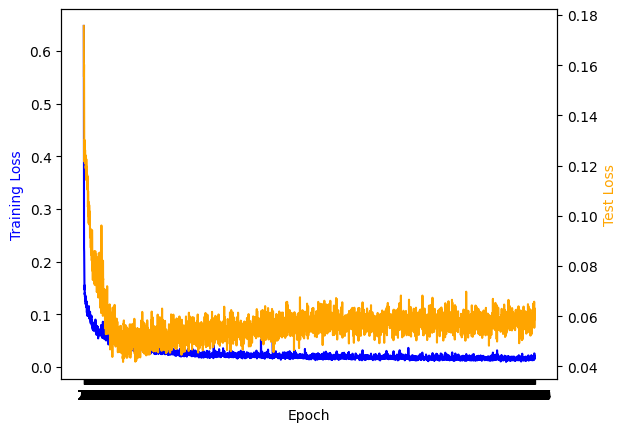

100%|██████████| 4000/4000 [00:19<00:00, 202.40it/s]

 Best Test Loss: 0.04181677848100662


In [13]:
# Optimize model

network_dict = {
    "network": VariableANN,
    "kwargs": {"input_size": 2},
    "optimize_kwargs": {
        "dropout": {"name": "dropout", "low": 0.0, "high": 0.5, "step": 0.05},
        "neurons": {"name": "neurons", "low": 16, "high": 256, "step": 16, "multi": np.random.randint(3, 6)},
    },
}


optimizer_dict = {
    "optimizer": optim.Adam,
    "kwargs": {},
    "optimize_kwargs": {
        "lr": {"name": "lr", "low": 1e-5, "high": 1e-1, "log": True},
        "weight_decay": {"name": "weight_decay", "low": 1e-5, "high": 1e-3, "log": True},
    },
}

best_network, best_optimizer = model.optimize_network(
    trial_count, "minimize", network_dict, optimizer_dict, loss_fn, epochs
)

trained_net = model.train_model("Model1", best_network, best_optimizer, loss_fn, 4000, plot_output=True)

RMSE: 0.029587
MAE: 0.023791


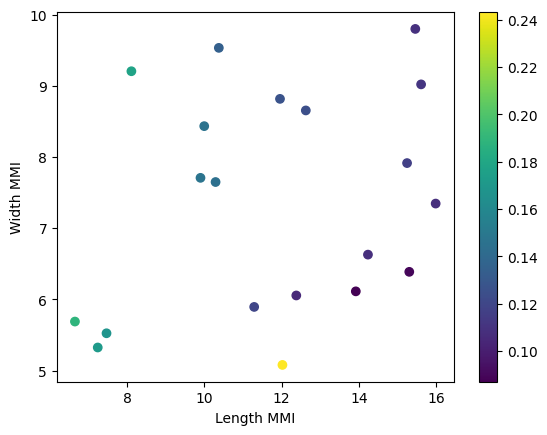

In [22]:
test_rmse, _, test_predictions = model.validate_model(trained_net, "test")

features = [x for x, _ in model.test_loaded]
combined = torch.concat(features)
l = [model.feature_scaler[0].inverse_transform(row[0].reshape(1, -1)) for row in combined]
w = [model.feature_scaler[1].inverse_transform(row[1].reshape(1, -1)) for row in combined]

T1_val = [row[0] for row in test_predictions]

scatter = plt.scatter(l, w, c=T1_val)
plt.xlabel("Length MMI")
plt.ylabel("Width MMI")
plt.colorbar(scatter)
plt.show()

## Optimizing with Predictions

Create a single function `run_fn` that takes suggested values and makes a prediction of transmition. Take the mean predicted value as an arbitrary loss function

In [14]:
def run_fn(L_MMI, W_MMI):
    feature_array = np.array((L_MMI, W_MMI))
    feature_array = feature_array.reshape((1, -1))
    prediction = model.make_prediction(trained_net, True, feature_array, 2)

    # return prediction[0]
    return -(abs(prediction[0] - 0.25)**2 + abs(prediction[1] - 0.25)**2)

Use Bayesian optimization evaluating the AI model to determine the best width and length parameters.

In [15]:
method = tdd.MethodBayOpt(
    initial_iter=500,
    n_iter=100,
    acq_func='ucb',
    kappa=10,
    xi=0.9,
    seed=1,
)

output_dir = "/home/matt/Documents/Flexcompute/mmi/data"
design_space = tdd.DesignSpace(
    method=method,
    parameters=parameters,
    task_name="mmi_predict_1",
    folder_name="MMIV1",
    path_dir=output_dir,
)

In [16]:
predict_results = design_space.run(run_fn, verbose=True)
predict_df = predict_results.to_dataframe()

08:58:59 BST Best Fit from Initial Solutions: -0.001                            
             

08:59:06 BST Latest Best Fit on Iter 8: -0.0                                    
             

08:59:07 BST Latest Best Fit on Iter 9: -0.0                                    
             

09:00:14 BST Latest Best Fit on Iter 93: -0.0                                   
             

09:00:20 BST Best Result: -0.00028004707544426743                               
             Best Parameters: L_MMI: 8.935825034041084 W_MMI: 5.0017857985496015
             

In [17]:
a = model.train_labels

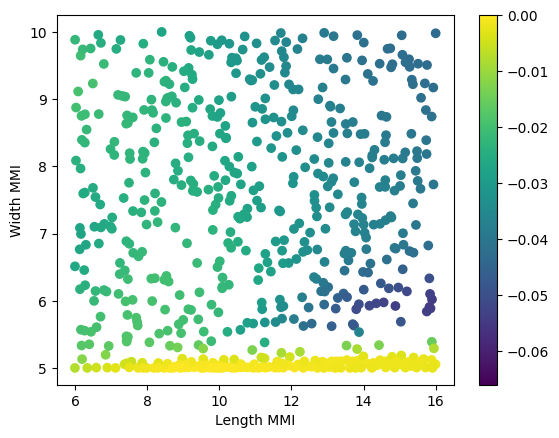

In [18]:
predict_scatter = plt.scatter(predict_df["L_MMI"], predict_df["W_MMI"], c=predict_df["output"], norm=norm)
plt.xlabel("Length MMI")
plt.ylabel("Width MMI")
plt.colorbar(predict_scatter)
plt.show()

## Analyse

In [19]:
import tidy3d.web as web
import random

sample_count = 20
random.seed(1)
# Build a batch with the best result and a selection of other results
sims = {"best": make_sim(**predict_results.optimizer.max["params"])}
random_vals = random.sample(predict_results.optimizer.res, sample_count)
for i in range(sample_count):
    sims[i] = make_sim(**random_vals[i]["params"])

sim_data = web.Batch(simulations=sims).run()

Output()

09:01:35 BST Started working on Batch containing 21 tasks.

09:03:22 BST Maximum FlexCredit cost: 7.801 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

09:07:48 BST Batch complete.

Output()

In [20]:
def pred(L_MMI, W_MMI):    
    feature_array = np.array((L_MMI, W_MMI))
    feature_array = feature_array.reshape((1, -1))
    prediction = model.make_prediction(trained_net, True, feature_array, 2)

    return prediction

In [23]:
difference = []
for key, res in sim_data.items():
    if key == "1": # Skipping this value as dummy replicate BO has picked very different option
        continue

    if key == "best":
        params = predict_results.optimizer.max["params"]
    else:
        params = random_vals[int(key)]["params"]
    
    prediction = pred(**params)

    T_dict = fn_post(res)
    t1_diff = abs(prediction[0] - float(T_dict['T1'][50]))
    t2_diff = abs(prediction[1] - float(T_dict['T2'][50]))
    difference.append(sum([t1_diff, t2_diff]))

mean_diff = sum(difference) / len(difference)
print(f"Mean Difference: {mean_diff}")
    


09:22:21 BST WARNING: Simulation final field decay value of 3.71e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

09:22:22 BST WARNING: Simulation final field decay value of 2.34e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

09:22:27 BST WARNING: Simulation final field decay value of 2.28e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

Mean Difference: 0.041345419734716414
